# This is Part 4 Notepook - Modeling

In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import time  
import ast
import pytz

from sklearn.dummy import DummyClassifier
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report 
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, log_loss, roc_auc_score
from sklearn.metrics import precision_recall_curve, make_scorer
from sklearn.metrics import roc_curve, auc


from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, HalvingGridSearchCV, HalvingRandomSearchCV
import warnings
warnings.filterwarnings('ignore')

In [39]:
df = pd.read_csv(r"C:\Users\dkaza\Documents\0 Berkeley - ML and AI\0_Capstone\encoded_w_outliers.csv")

In [40]:
df.head()

,user_is_clicker,premium_inventory,target,bun_ctr_30d_quan,u_imp_depth_offer_d90_quan,u_imp_depth_camp_d90_quan,u_click_depth_camp_d90_quan,request_make_Alcatel,request_make_Apple,request_make_Asus,...,user_primary_category_d90_83.0,user_primary_category_d90_84.0,user_primary_category_d90_85.0,user_primary_category_d90_86.0,user_primary_category_d90_87.0,user_primary_category_d90_88.0,user_primary_category_d90_89.0,user_primary_category_d90_90.0,user_primary_category_d90_95.0,user_primary_category_d90_162.0
0,0,1,0,-0.354598,-0.025031,0.531117,-1.487503,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,-0.229665,0.617278,0.565332,-1.487503,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0.655191,-2.482584,-1.896532,-1.487503,0,1,0,...,0,1,0,0,0,0,0,0,0,0
3,0,0,0,-1.484742,0.484569,0.565332,-1.487503,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,1,0,-1.327349,0.210790,0.351027,0.551172,0,1,0,...,0,0,0,0,0,0,0,0,0,0


In [41]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9804 entries, 0 to 9803
Columns: 247 entries, user_is_clicker to user_primary_category_d90_162.0
dtypes: float64(4), int64(243)
memory usage: 18.5 MB


In [42]:
X = df.drop(['target'],axis=1)
y = df['target']

In [43]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.3,random_state=1,stratify=y)

In [44]:
X_train.shape

(6862, 246)

In [45]:
X_test.shape

(2942, 246)

In [9]:
#Let us define a dataframe to store performance of our future awesome models
columns = ['Model Name', 'Elapsed Time', 'Accuracy', 'Precision', 'Recall', 'F1 Score', 'ROC AUC', 'Log Loss']
performance_df = pd.DataFrame(columns=columns)

In [46]:
# Function to add model's performance to the DataFrame
def add_model_performance(performance_df, model_name, elapsed_time, accuracy, precision, recall, f1, roc_auc, log_loss_value):
    new_row = {
        'Model Name': model_name,
        'Elapsed Time': elapsed_time,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1,
        'ROC AUC': roc_auc,
        'Log Loss': log_loss_value
    }
    return performance_df.append(new_row, ignore_index=True)

In [11]:
def summarize_model_performance(model, X_test, y_test, model_name, elapsed_time, performance_df):
    """
    Summarize and plot the performance of a trained model and add its performance metrics to an existing DataFrame.

    Parameters:
    model (Classifier): The trained model.
    X_test (DataFrame): Test features.
    y_test (Series): True labels for the test set.
    model_name (str): Name of the model.
    elapsed_time (float): Training time for the model.
    performance_df (DataFrame): DataFrame to store performance metrics.

    Returns:
    DataFrame: Updated performance DataFrame with the new model's metrics.
    """

    # Make predictions on the test data
    y_pred = model.predict(X_test)

    # Compute the confusion matrix
    confusion = confusion_matrix(y_test, y_pred)

    # Compute ROC curve and ROC AUC
    y_prob = model.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)

    # Create a figure with two subplots for confusion matrix and ROC curve
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    # Plot the confusion matrix
    sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues', cbar=False, ax=axes[0])
    axes[0].set_title('Confusion Matrix')
    axes[0].set_xlabel('Predicted')
    axes[0].set_ylabel('Actual')

    # Plot the ROC curve
    axes[1].plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC AUC = {roc_auc:.2f}')
    axes[1].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    axes[1].set_xlim([0.0, 1.0])
    axes[1].set_ylim([0.0, 1.0])
    axes[1].set_xlabel('False Positive Rate')
    axes[1].set_ylabel('True Positive Rate')
    axes[1].set_title('ROC Curve')
    axes[1].legend(loc='lower right')

    plt.tight_layout()
    plt.show()

    # Compute main metrics 
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred)
    log_loss_value = log_loss(y_test, y_prob)

    # Update the performance DataFrame
    performance_df = add_model_performance(performance_df, model_name, elapsed_time, accuracy, precision, recall, f1, roc_auc, log_loss_value)

    return performance_df

# Baseline Model

Before we build our first model, we want to create a dummy classifier baseline

In [12]:
model_name = "Baseline"

# Create a dummy classifier that predicts the majority class (0)
dummy_classifier = DummyClassifier(strategy='most_frequent')

# Start the timer
start_time = time.time()

# Train the dummy classifier on the training data
dummy_classifier.fit(X_train, y_train)

# End the timer
end_time = time.time()
elapsed_time = end_time - start_time

In [13]:
elapsed_time

0.0009672641754150391

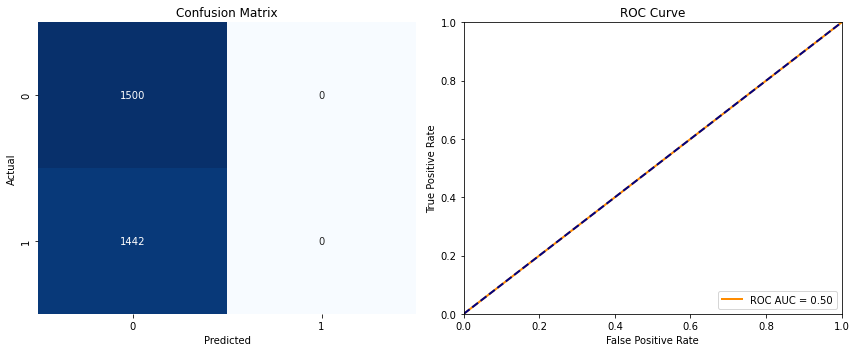

,Model Name,Elapsed Time,Accuracy,Precision,Recall,F1 Score,ROC AUC,Log Loss
0,Baseline,0.000967,0.509857,0.0,0.0,0.0,0.5,16.928931


In [14]:
model = dummy_classifier
performance_df = summarize_model_performance(model, X_test, y_test, model_name, elapsed_time, performance_df)
performance_df

## Observation:
- As expected, the dummy classifier classifies everything as Class 0 (majority class)
- The metrics are pretty bad too

# Decision Tree - Basic

In [15]:
model_name = "Decision Tree - Basic"

# Start the timer
start_time = time.time()

# Create a DecisionTreeClassifier
dt_classifier = DecisionTreeClassifier(random_state=42)

# Fit the model on the training data
dt_classifier.fit(X_train, y_train)

# End the timer
end_time = time.time()

elapsed_time = end_time - start_time
print('Elapsed Time:', elapsed_time)

Elapsed Time: 0.05569958686828613


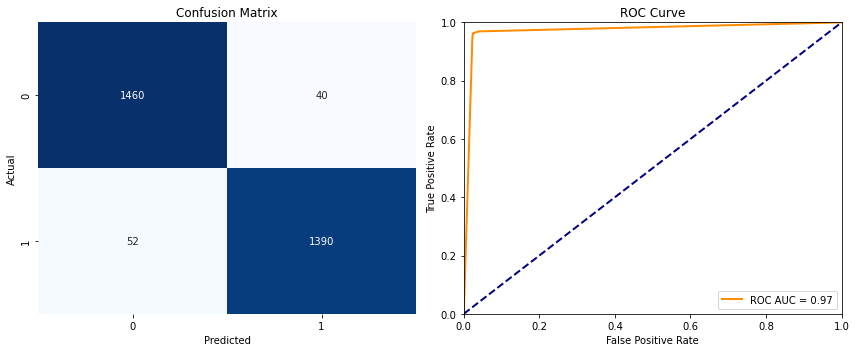

,Model Name,Elapsed Time,Accuracy,Precision,Recall,F1 Score,ROC AUC,Log Loss
0,Baseline,0.000967,0.509857,0.000000,0.000000,0.000000,0.500000,16.928931
1,Decision Tree - Basic,0.055700,0.968729,0.972028,0.963939,0.967967,0.968636,0.927700


In [16]:
# Let us check performance
model = dt_classifier
performance_df = summarize_model_performance(model, X_test, y_test, model_name, elapsed_time, performance_df)
performance_df

# Observation:
- Not too shabby! Basic Decision Tree perforamance against Test data is very nice!
- Compared to the dummy classifier, LogLoss dropped from 16.93 to 0.9

# Decision Tree - Optimized

In [17]:
model_name = "Decision Tree - Optimized"

# Start the timer
start_time = time.time()

# Define the hyperparameters and their possible values
param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None] + list(range(5, 51, 5)),
    'min_samples_split': [2, 4, 6, 8, 10],
    'min_samples_leaf': [1, 2, 4, 6]
}

# Create a GridSearchCV object with custom scoring
grid_search = GridSearchCV(
    DecisionTreeClassifier(random_state=42),
    param_grid,
    cv=5,
    verbose=2,
    n_jobs=-1,
    scoring='neg_log_loss'
)

# Fit the GridSearchCV object to the training data
grid_search.fit(X_train, y_train)

# End the timer
end_time = time.time()

elapsed_time = end_time - start_time
print('Elapsed Time:', elapsed_time)

# Get the best estimator (best model)
best_dt_classifier = grid_search.best_estimator_

# Print the best hyperparameters
print("Best Hyperparameters:", grid_search.best_params_)

Fitting 5 folds for each of 440 candidates, totalling 2200 fits
Elapsed Time: 27.06475853919983
Best Hyperparameters: {'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 6, 'min_samples_split': 2}


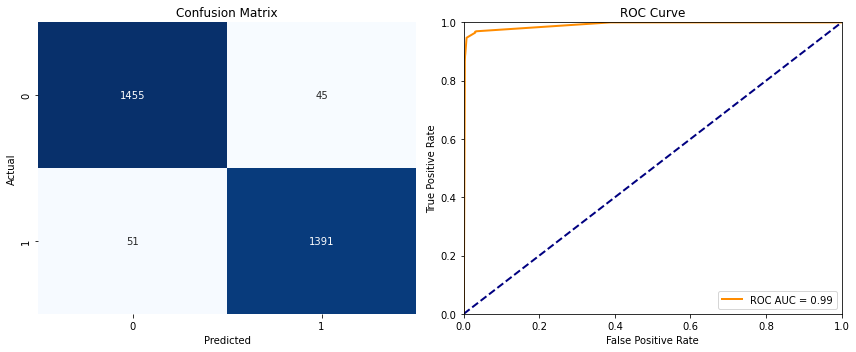

,Model Name,Elapsed Time,Accuracy,Precision,Recall,F1 Score,ROC AUC,Log Loss
0,Baseline,0.000967,0.509857,0.000000,0.000000,0.000000,0.500000,16.928931
1,Decision Tree - Basic,0.055700,0.968729,0.972028,0.963939,0.967967,0.968636,0.927700
2,Decision Tree - Optimized,27.064759,0.967369,0.968663,0.964632,0.966644,0.967316,0.127090


In [18]:
# Let us check performance
model = best_dt_classifier
performance_df = summarize_model_performance(model, X_test, y_test, model_name, elapsed_time, performance_df)
performance_df

## Observation:
LogLoss Improved quite a bit from 0.9 for unoptimized tree to just 0.15 

# Random Forest - Basic

In [19]:
model_name = "Random Forest - Basic"

# Start the timer
start_time = time.time()

# Create a RandomForestClassifier with default parameters
rf_classifier = RandomForestClassifier(random_state=42)

# Fit the model on the training data
rf_classifier.fit(X_train, y_train)

# End the timer
end_time = time.time()

elapsed_time = end_time - start_time
print('Elapsed Time:', elapsed_time)

Elapsed Time: 0.6462059020996094


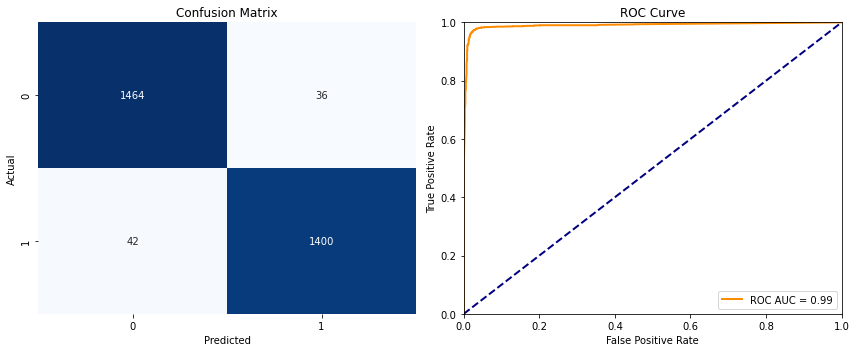

,Model Name,Elapsed Time,Accuracy,Precision,Recall,F1 Score,ROC AUC,Log Loss
0,Baseline,0.000967,0.509857,0.000000,0.000000,0.000000,0.500000,16.928931
1,Decision Tree - Basic,0.055700,0.968729,0.972028,0.963939,0.967967,0.968636,0.927700
2,Decision Tree - Optimized,27.064759,0.967369,0.968663,0.964632,0.966644,0.967316,0.127090
3,Random Forest - Basic,0.646206,0.973487,0.974930,0.970874,0.972898,0.973437,0.192965


In [20]:
# Let us check performance
model = rf_classifier
performance_df = summarize_model_performance(model, X_test, y_test, model_name, elapsed_time, performance_df)
performance_df

## Observation:
- LogLoss for Basic Random Forest is quite a bit better than for Basic Tree (0.2 vs 0.9). However, it is still worse than the optimise Tree LogLos, which was 0.15.
- All other parameters look great. 
- Let us see if we can further finetune the model through Hyperparameter Tuning

# Random Forest - Optimized

In [21]:
model_name = "Random Forest - Optimized"

# Define the hyperparameters and their possible values
param_grid = {
    'n_estimators': [50, 100, 200, 300],  # Number of trees in the forest
    'max_depth': [None, 10, 20, 30, 40, 50],  # Maximum depth of the tree
    'min_samples_split': [2, 5, 10],  # Minimum number of samples required to split an internal node
    'min_samples_leaf': [1, 2, 4]     # Minimum number of samples required to be at a leaf node
    # Add other parameters if needed
}

# Create a GridSearchCV object with LogLoss scoring
grid_search = GridSearchCV(
    RandomForestClassifier(random_state=42),
    param_grid,
    cv=5,
    verbose=2,
    n_jobs=-1,
    scoring='neg_log_loss'
)

# Fit the GridSearchCV object to the training data
grid_search.fit(X_train, y_train)

# End the timer
end_time = time.time()

elapsed_time = end_time - start_time
print('Elapsed Time:', elapsed_time)

# Get the best estimator (best model)
best_rf_classifier = grid_search.best_estimator_

# Print the best hyperparameters
print("Best Hyperparameters:", grid_search.best_params_)

Fitting 5 folds for each of 216 candidates, totalling 1080 fits
Elapsed Time: 190.96170043945312
Best Hyperparameters: {'max_depth': 30, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}


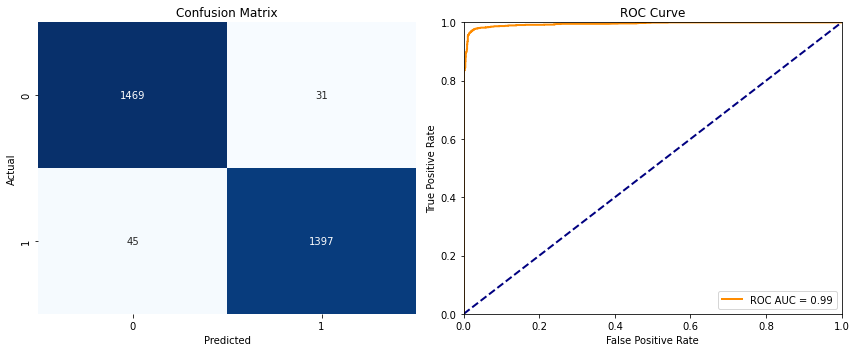

,Model Name,Elapsed Time,Accuracy,Precision,Recall,F1 Score,ROC AUC,Log Loss
0,Baseline,0.000967,0.509857,0.000000,0.000000,0.000000,0.500000,16.928931
1,Decision Tree - Basic,0.055700,0.968729,0.972028,0.963939,0.967967,0.968636,0.927700
2,Decision Tree - Optimized,27.064759,0.967369,0.968663,0.964632,0.966644,0.967316,0.127090
3,Random Forest - Basic,0.646206,0.973487,0.974930,0.970874,0.972898,0.973437,0.192965
4,Random Forest - Optimized,190.961700,0.974167,0.978291,0.968793,0.973519,0.974063,0.089496


In [22]:
# Let us check performance
model = best_rf_classifier
performance_df = summarize_model_performance(model, X_test, y_test, model_name, elapsed_time, performance_df)
performance_df

## Observation:
- Damn Nice! LogLoss is now only 0.09!
- Other parameters also look great. 

# Logistic Regression - Basic Model


In [23]:
model_name = "Logistic Regression - Basic"
# Start measuring time
start_time = time.time()

# Create a Logistic Regression model
logistic_model = LogisticRegression(random_state=1, max_iter=1000)

# Train the model on the training data
logistic_model.fit(X_train, y_train)

# Stop measuring time
end_time = time.time()

# Calculate the elapsed time
elapsed_time = end_time - start_time
print('Elapsed Time:', elapsed_time)


Elapsed Time: 0.11073756217956543


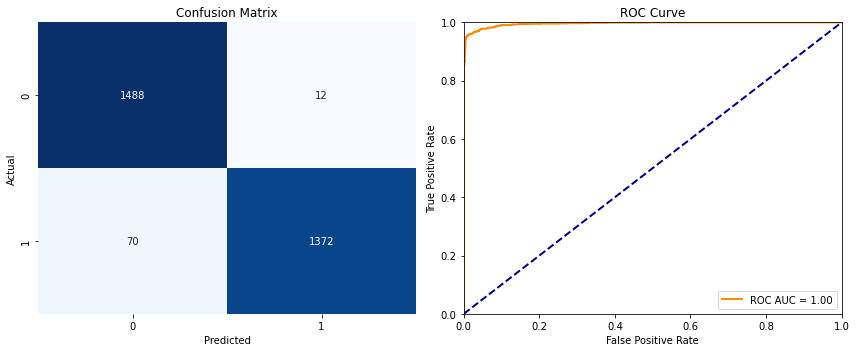

,Model Name,Elapsed Time,Accuracy,Precision,Recall,F1 Score,ROC AUC,Log Loss
0,Baseline,0.000967,0.509857,0.000000,0.000000,0.000000,0.500000,16.928931
1,Decision Tree - Basic,0.055700,0.968729,0.972028,0.963939,0.967967,0.968636,0.927700
2,Decision Tree - Optimized,27.064759,0.967369,0.968663,0.964632,0.966644,0.967316,0.127090
3,Random Forest - Basic,0.646206,0.973487,0.974930,0.970874,0.972898,0.973437,0.192965
4,Random Forest - Optimized,190.961700,0.974167,0.978291,0.968793,0.973519,0.974063,0.089496
5,Logistic Regression - Basic,0.110738,0.972128,0.991329,0.951456,0.970984,0.971728,0.078890


In [24]:
# Let us check performance
model = logistic_model
performance_df = summarize_model_performance(model, X_test, y_test, model_name, elapsed_time, performance_df)
performance_df

## Obsrvation:
- Off the shelf Logistic Regression is very very nice! 
- LogLoss is under 0.09 --even without hyperparamter tuning.

## Optimized Logistic Regression

We will want to optimize to LogLoss (negative log Loss, since the optimizer is mazimizing the function)

In [25]:
model_name = "Logistic Regression - Optimized"

# Start measuring time
start_time = time.time()

# Define the hyperparameters and their possible values
param_grid = {
    'C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear', 'saga'],
    'max_iter': [5000, 10000]
}

# Create a GridSearchCV object
grid_search = GridSearchCV(LogisticRegression(random_state=1), 
                           param_grid,
                           cv=5,
                           verbose=2,
                           n_jobs=-1,
                          scoring='neg_log_loss'
                          )

# Fit the GridSearchCV object to the training data
grid_search.fit(X_train, y_train)

# Stop measuring time
end_time = time.time()

# Calculate the elapsed time
elapsed_time = end_time - start_time
print('Elapsed Time:', elapsed_time)

# Retrieve the best hyperparameters and the best estimator
best_params = grid_search.best_params_
best_lr = grid_search.best_estimator_

# Print Training / Search time and Best Hyperparameters
print("Best Hyperparameters:", best_params)

Fitting 5 folds for each of 56 candidates, totalling 280 fits
Elapsed Time: 236.3072464466095
Best Hyperparameters: {'C': 1, 'max_iter': 5000, 'penalty': 'l1', 'solver': 'saga'}


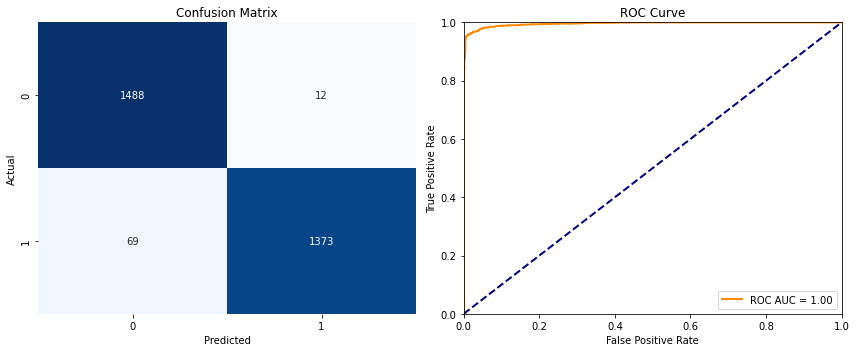

,Model Name,Elapsed Time,Accuracy,Precision,Recall,F1 Score,ROC AUC,Log Loss
0,Baseline,0.000967,0.509857,0.000000,0.000000,0.000000,0.500000,16.928931
1,Decision Tree - Basic,0.055700,0.968729,0.972028,0.963939,0.967967,0.968636,0.927700
2,Decision Tree - Optimized,27.064759,0.967369,0.968663,0.964632,0.966644,0.967316,0.127090
3,Random Forest - Basic,0.646206,0.973487,0.974930,0.970874,0.972898,0.973437,0.192965
4,Random Forest - Optimized,190.961700,0.974167,0.978291,0.968793,0.973519,0.974063,0.089496
5,Logistic Regression - Basic,0.110738,0.972128,0.991329,0.951456,0.970984,0.971728,0.078890
6,Logistic Regression - Optimized,236.307246,0.972468,0.991336,0.952150,0.971348,0.972075,0.080955


In [26]:
# Let us check performance
model = best_lr
performance_df = summarize_model_performance(model, X_test, y_test, model_name, elapsed_time, performance_df)
performance_df

## Observation:
- Not much of ain improvement by optimizing logistic regression.

# KNN - Basic

In [27]:
model_name = "KNN - Basic"

# instantiate the model (using the default parameters)
KNN = KNeighborsClassifier()

# Start the timer
start_time = time.time()

# fit the model with data
KNN.fit(X_train, y_train)

# End the timer
end_time = time.time()

# Calculate the difference
elapsed_time = end_time - start_time

print('Elapsed Time:', elapsed_time)

y_pred = KNN.predict(X_test)
KNN_score_train = KNN.score(X_train, y_train)
KNN_score_test = KNN.score(X_test, y_test)
print('KNN Score Train:', KNN_score_train)
print('KNN Score Test:', KNN_score_test)

Elapsed Time: 0.007982015609741211
KNN Score Train: 0.9793063246866802
KNN Score Test: 0.9707681849082257


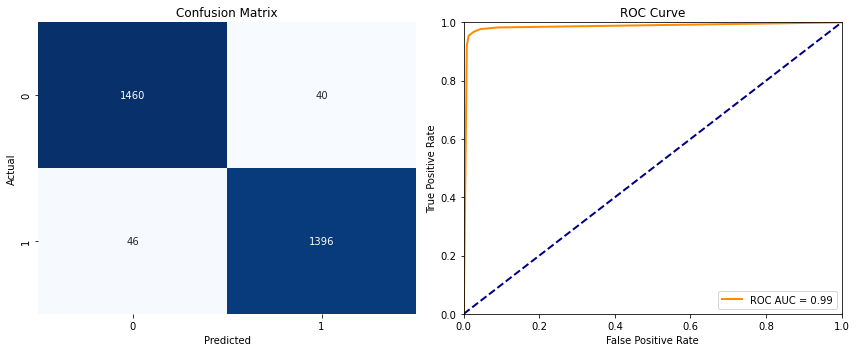

,Model Name,Elapsed Time,Accuracy,Precision,Recall,F1 Score,ROC AUC,Log Loss
0,Baseline,0.000967,0.509857,0.000000,0.000000,0.000000,0.500000,16.928931
1,Decision Tree - Basic,0.055700,0.968729,0.972028,0.963939,0.967967,0.968636,0.927700
2,Decision Tree - Optimized,27.064759,0.967369,0.968663,0.964632,0.966644,0.967316,0.127090
3,Random Forest - Basic,0.646206,0.973487,0.974930,0.970874,0.972898,0.973437,0.192965
4,Random Forest - Optimized,190.961700,0.974167,0.978291,0.968793,0.973519,0.974063,0.089496
5,Logistic Regression - Basic,0.110738,0.972128,0.991329,0.951456,0.970984,0.971728,0.078890
6,Logistic Regression - Optimized,236.307246,0.972468,0.991336,0.952150,0.971348,0.972075,0.080955
7,KNN - Basic,0.007982,0.970768,0.972145,0.968100,0.970118,0.970717,0.470134


In [28]:
# Let us check performance
model = KNN
performance_df = summarize_model_performance(model, X_test, y_test, model_name, elapsed_time, performance_df)
performance_df

## Observations:
- Not the best performace for the out of box KNN compared to some other models

# KNN - Optimized

In [29]:
model_name = "KNN - Optimized"

# Define the hyperparameters and their possible values
param_grid = {
    'n_neighbors': [3, 5, 7, 9, 11, 13, 15], 
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}

# Start the timer
start_time = time.time()

# Create a GridSearchCV object
grid_search = GridSearchCV(
    KNeighborsClassifier(),
    param_grid,
    cv=5,
    verbose=2,
    n_jobs=-1,
    scoring='neg_log_loss'
)

# Fit the GridSearchCV object to the training data
grid_search.fit(X_train, y_train)

# End the timer
end_time = time.time()

elapsed_time = end_time - start_time
print('Elapsed Time:', elapsed_time)

# Print the best parameters
print("Best hyperparameters:", grid_search.best_params_)

# Refit the KNN model using the best hyperparameters
best_knn = grid_search.best_estimator_

Fitting 5 folds for each of 28 candidates, totalling 140 fits
Elapsed Time: 59.846455812454224
Best hyperparameters: {'metric': 'manhattan', 'n_neighbors': 15, 'weights': 'uniform'}


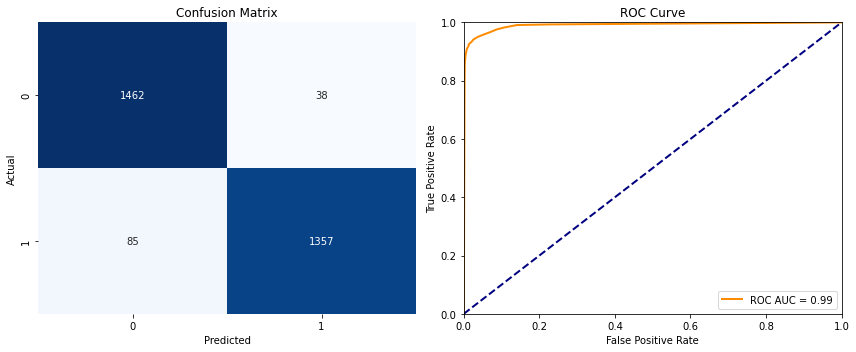

,Model Name,Elapsed Time,Accuracy,Precision,Recall,F1 Score,ROC AUC,Log Loss
0,Baseline,0.000967,0.509857,0.000000,0.000000,0.000000,0.500000,16.928931
1,Decision Tree - Basic,0.055700,0.968729,0.972028,0.963939,0.967967,0.968636,0.927700
2,Decision Tree - Optimized,27.064759,0.967369,0.968663,0.964632,0.966644,0.967316,0.127090
3,Random Forest - Basic,0.646206,0.973487,0.974930,0.970874,0.972898,0.973437,0.192965
4,Random Forest - Optimized,190.961700,0.974167,0.978291,0.968793,0.973519,0.974063,0.089496
5,Logistic Regression - Basic,0.110738,0.972128,0.991329,0.951456,0.970984,0.971728,0.078890
6,Logistic Regression - Optimized,236.307246,0.972468,0.991336,0.952150,0.971348,0.972075,0.080955
7,KNN - Basic,0.007982,0.970768,0.972145,0.968100,0.970118,0.970717,0.470134
8,KNN - Optimized,59.846456,0.958192,0.972760,0.941054,0.956644,0.957860,0.236475


In [30]:
# Let us check performance
model = best_knn
performance_df = summarize_model_performance(model, X_test, y_test, model_name, elapsed_time, performance_df)
performance_df

# Basic SVM

In [31]:
model_name = "SVM - Basic"

# Start the timer
start_time = time.time()

# Create the SVC model with probability enabled
svc = SVC(probability=True, random_state=42)
svc.fit(X_train, y_train)

# End the timer and calculate the elapsed time
end_time = time.time()
elapsed_time = end_time - start_time
print('Elapsed Time:', elapsed_time)

Elapsed Time: 5.061740398406982


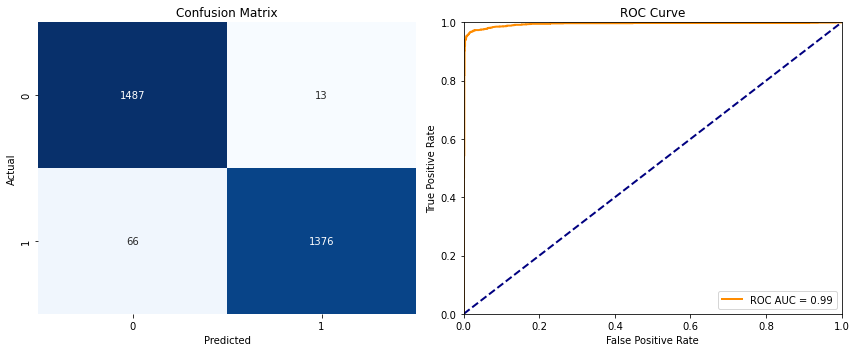

,Model Name,Elapsed Time,Accuracy,Precision,Recall,F1 Score,ROC AUC,Log Loss
0,Baseline,0.000967,0.509857,0.000000,0.000000,0.000000,0.500000,16.928931
1,Decision Tree - Basic,0.055700,0.968729,0.972028,0.963939,0.967967,0.968636,0.927700
2,Decision Tree - Optimized,27.064759,0.967369,0.968663,0.964632,0.966644,0.967316,0.127090
3,Random Forest - Basic,0.646206,0.973487,0.974930,0.970874,0.972898,0.973437,0.192965
4,Random Forest - Optimized,190.961700,0.974167,0.978291,0.968793,0.973519,0.974063,0.089496
5,Logistic Regression - Basic,0.110738,0.972128,0.991329,0.951456,0.970984,0.971728,0.078890
6,Logistic Regression - Optimized,236.307246,0.972468,0.991336,0.952150,0.971348,0.972075,0.080955
7,KNN - Basic,0.007982,0.970768,0.972145,0.968100,0.970118,0.970717,0.470134
8,KNN - Optimized,59.846456,0.958192,0.972760,0.941054,0.956644,0.957860,0.236475
9,SVM - Basic,5.061740,0.973148,0.990641,0.954230,0.972095,0.972782,0.087060


In [32]:
# Let us check performance
model = svc
performance_df = summarize_model_performance(model, X_test, y_test, model_name, elapsed_time, performance_df)
performance_df

## Observation:
 - Not a bad Log Loss out of the box for SVM!

# SVM - Optimized

In [33]:
model_name = "SVM - Optimized"

# Start the timer
start_time = time.time()

# Define the hyperparameters and their possible values
param_grid = {
    'C': [0.1, 1, 10, 100],  # Regularization parameter
    'gamma': [1, 0.1, 0.01, 0.001],  # Kernel coefficient
    'kernel': ['rbf', 'poly', 'sigmoid']  # Specifies the kernel type to be used in the algorithm
}

# Create a GridSearchCV object
grid_search = GridSearchCV(
    SVC(probability=True, random_state=42),  # Enable probability for ROC AUC
    param_grid,
    cv=5,
    verbose=2,
    n_jobs=-1,
    scoring='neg_log_loss'  # Optimize for LogLoss
)

# Fit the GridSearchCV object to the training data
grid_search.fit(X_train, y_train)

# End the timer
end_time = time.time()

# Calculate the elapsed time
elapsed_time = end_time - start_time
print('Elapsed Time:', elapsed_time)

# Get the best estimator (best model)
best_svc = grid_search.best_estimator_

# Print the best hyperparameters
print("Best Hyperparameters:", grid_search.best_params_)

Fitting 5 folds for each of 48 candidates, totalling 240 fits
Elapsed Time: 1035.3699955940247
Best Hyperparameters: {'C': 100, 'gamma': 0.01, 'kernel': 'rbf'}


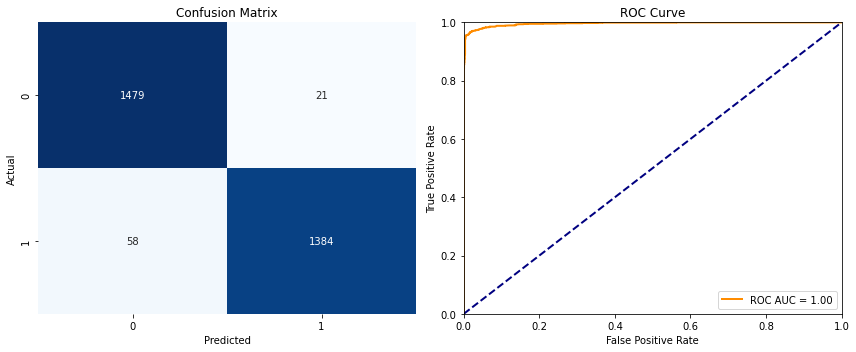

,Model Name,Elapsed Time,Accuracy,Precision,Recall,F1 Score,ROC AUC,Log Loss
0,Baseline,0.000967,0.509857,0.000000,0.000000,0.000000,0.500000,16.928931
1,Decision Tree - Basic,0.055700,0.968729,0.972028,0.963939,0.967967,0.968636,0.927700
2,Decision Tree - Optimized,27.064759,0.967369,0.968663,0.964632,0.966644,0.967316,0.127090
3,Random Forest - Basic,0.646206,0.973487,0.974930,0.970874,0.972898,0.973437,0.192965
4,Random Forest - Optimized,190.961700,0.974167,0.978291,0.968793,0.973519,0.974063,0.089496
5,Logistic Regression - Basic,0.110738,0.972128,0.991329,0.951456,0.970984,0.971728,0.078890
6,Logistic Regression - Optimized,236.307246,0.972468,0.991336,0.952150,0.971348,0.972075,0.080955
7,KNN - Basic,0.007982,0.970768,0.972145,0.968100,0.970118,0.970717,0.470134
8,KNN - Optimized,59.846456,0.958192,0.972760,0.941054,0.956644,0.957860,0.236475
9,SVM - Basic,5.061740,0.973148,0.990641,0.954230,0.972095,0.972782,0.087060


In [34]:
# Let us check performance
model = best_svc
performance_df = summarize_model_performance(model, X_test, y_test, model_name, elapsed_time, performance_df)
performance_df

## Observations:
- SVM Grid Seach took a long time
- LogLoss improved slightly: from 0.11 to 0.1

## Observation
- A decent improvement in LogLoss

# Summary

In [35]:
performance_df

,Model Name,Elapsed Time,Accuracy,Precision,Recall,F1 Score,ROC AUC,Log Loss
0,Baseline,0.000967,0.509857,0.000000,0.000000,0.000000,0.500000,16.928931
1,Decision Tree - Basic,0.055700,0.968729,0.972028,0.963939,0.967967,0.968636,0.927700
2,Decision Tree - Optimized,27.064759,0.967369,0.968663,0.964632,0.966644,0.967316,0.127090
3,Random Forest - Basic,0.646206,0.973487,0.974930,0.970874,0.972898,0.973437,0.192965
4,Random Forest - Optimized,190.961700,0.974167,0.978291,0.968793,0.973519,0.974063,0.089496
5,Logistic Regression - Basic,0.110738,0.972128,0.991329,0.951456,0.970984,0.971728,0.078890
6,Logistic Regression - Optimized,236.307246,0.972468,0.991336,0.952150,0.971348,0.972075,0.080955
7,KNN - Basic,0.007982,0.970768,0.972145,0.968100,0.970118,0.970717,0.470134
8,KNN - Optimized,59.846456,0.958192,0.972760,0.941054,0.956644,0.957860,0.236475
9,SVM - Basic,5.061740,0.973148,0.990641,0.954230,0.972095,0.972782,0.087060


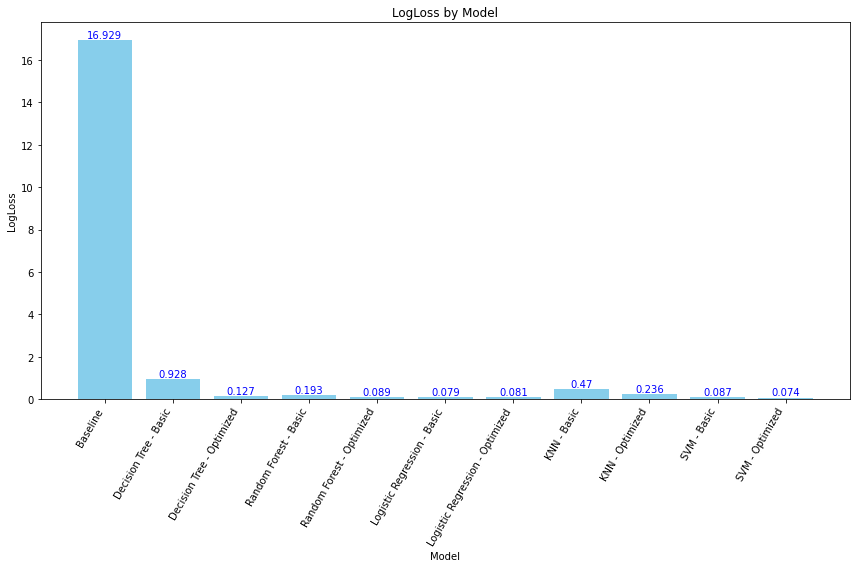

In [36]:
# Plotting the bar graph for LogLoss by Model with annotations
plt.figure(figsize=(12, 8))
bars = plt.bar(performance_df['Model Name'], performance_df['Log Loss'], color='skyblue')

# Adding the text annotations on the bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 3), va='bottom', ha='center', color='blue')

plt.xlabel('Model')
plt.ylabel('LogLoss')
plt.title('LogLoss by Model')
plt.xticks(rotation=60, ha='right')
plt.tight_layout()
plt.show()


In [37]:
#Let us export the performance datafraome to .csv
performance_df.to_csv(r"C:\Users\dkaza\Documents\0 Berkeley - ML and AI\0_Capstone\performance_df.csv", index=False)